In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Optimize display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries installed and imported successfully")


✓ Libraries installed and imported successfully


In [2]:
# Cell 2: Load the dataset
df = pd.read_csv('/Users/harryyip/Downloads/wintermute_transfers_search_default_2025-04-08.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("Column names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()


Dataset loaded successfully!
Shape: 437,000 rows × 11 columns

Column names:
['timestamp', 'from_address', 'from_entity', 'to_address', 'to_entity', 'token', 'value', 'usd', 'tx_hash', 'chain', 'block_number']

First 5 rows:


,timestamp,from_address,from_entity,to_address,to_entity,token,value,usd,tx_hash,chain,block_number
0,2025-04-08 12:49:57+00:00,0xB1026b8e7276e7AC75410F1fcbbe21796e8f7526,Camelot,0x51C72848c68a965f66FA7a88855F9f7784502a7F,Wintermute,USDC,438.11,438.11,0x98058c529466064c355bdfea3cfebe399344678f20bb...,arbitrum_one,324218955.00
1,2025-04-08 12:49:54+00:00,0xcDa53B1F66614552F834cEeF361A8D12a0B8DaD8,Uniswap,0x51C72848c68a965f66FA7a88855F9f7784502a7F,Wintermute,ARB,3837.14,1062.88,0x405b146ac6a52b93e5a77760a4b49a87015b5c5e0659...,arbitrum_one,324218945.00
2,2025-04-08 12:49:51+00:00,0xb2cc224c1c9feE385f8ad6a55b4d94E92359DC59,Aerodrome Finance,0x51C72848c68a965f66FA7a88855F9f7784502a7F,Wintermute,WETH,7.35,11533.61,0x7f370fc61bed7241d846c4907a4e616e69ce60ff0192...,base,28663622.00
3,2025-04-08 12:49:51+00:00,0x51C72848c68a965f66FA7a88855F9f7784502a7F,Wintermute,0x72AB388E2E2F6FaceF59E3C3FA2C4E29011c2D38,PancakeSwap,USDC,2143.71,2143.71,0x88b4fb948e95cc2b9a22c48efe3d6a6788209302e72f...,base,28663622.00
4,2025-04-08 12:49:50+00:00,0x641C00A822e8b671738d32a431a4Fb6074E5c79d,Uniswap,0x51C72848c68a965f66FA7a88855F9f7784502a7F,Wintermute,WETH,0.47,737.55,0x39fc603c882c2f5af51b7f8cfc8eb58753f5e42eff94...,arbitrum_one,324218918.00


In [3]:
# Cell 3: Data Exploration & Quality Check
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(f"Total transactions: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total USD volume: ${df['usd'].sum():,.2f}")
print(f"Unique tokens: {df['token'].nunique()}")
print(f"Unique chains: {df['chain'].nunique()}")

# Identify counterparties (entities Wintermute interacted with)
# Wintermute can be either sender or receiver
wintermute_as_sender = df[df['from_entity'] == 'Wintermute']['to_entity'].value_counts()
wintermute_as_receiver = df[df['to_entity'] == 'Wintermute']['from_entity'].value_counts()

# Combine both
all_counterparties = pd.concat([wintermute_as_sender, wintermute_as_receiver]).groupby(level=0).sum().sort_values(ascending=False)

print(f"\nTotal unique counterparties: {len(all_counterparties)}")
print("\nTop 20 Counterparties by Transaction Count:")
print(all_counterparties.head(20))


DATA QUALITY ASSESSMENT

Missing Values:
timestamp           0
from_address       18
from_entity     33300
to_address         26
to_entity       29859
token              45
value               0
usd                 0
tx_hash            44
chain               0
block_number       44
dtype: int64

BASIC STATISTICS
Total transactions: 437,000
Date range: 2025-04-08 01:30:11+00:00 to 2025-04-08 12:49:57+00:00
Total USD volume: $1,979,602,062.20
Unique tokens: 168
Unique chains: 10

Total unique counterparties: 84

Top 20 Counterparties by Transaction Count:
Orca                         84105
Raydium                      82780
Uniswap                      51477
Jito                         48343
Meteora (Prev. Mercurial)    31702
PancakeSwap                  21608
Fluid (Instadapp)            13933
Camelot                      10729
Aerodrome Finance             9002
Phoenix                       6266
MetaMask                      2394
Velodrome Finance             2346
rsync-builder       

In [4]:
# Cell 4: Entity Classification (DeFi vs Non-DeFi)

# Define comprehensive classification based on known entities
DEFI_ENTITIES = {
    # DEXs (Decentralized Exchanges)
    'Uniswap', 'Raydium', 'Orca', 'PancakeSwap', 'Camelot', 'Aerodrome Finance',
    'Velodrome Finance', 'Curve.fi', 'Phoenix', 'Meteora (Prev. Mercurial)',
    'Sushiswap', 'Balancer', 'Trader Joe', 'Kyberswap',
    
    # DEX Aggregators
    'CoW Protocol', 'ParaSwap', '1inch', 'Bebop', 'MetaMask',
    
    # Lending/DeFi Protocols
    'Fluid (Instadapp)', 'Aave', 'Compound', 'MakerDAO', 'Instadapp',
    
    # Other DeFi Infrastructure
    'Jito',  # Solana MEV/staking
    'Rizzolver (Wintermute)',  # Wintermute's own resolver
}

CEX_ENTITIES = {
    'Binance', 'Coinbase', 'Kraken', 'OKX', 'Bybit', 'Bitfinex', 'Huobi', 'KuCoin'
}

BRIDGE_ENTITIES = {
    'Wormhole', 'Stargate', 'Synapse', 'Across', 'Hop Protocol'
}

MEV_BUILDER_ENTITIES = {
    'rsync-builder', 'Flashbots', 'Builder0x69'
}

def classify_entity(entity):
    """Classify entity as DeFi, CEX, Bridge, MEV, or Unknown"""
    if pd.isna(entity) or entity == '':
        return 'Unknown'
    elif entity in DEFI_ENTITIES:
        return 'DeFi'
    elif entity in CEX_ENTITIES:
        return 'CEX'
    elif entity in BRIDGE_ENTITIES:
        return 'Bridge'
    elif entity in MEV_BUILDER_ENTITIES:
        return 'MEV/Builder'
    elif entity == 'Wintermute':
        return 'Wintermute (Self)'
    else:
        return 'Unknown'

# Apply classification
df['from_entity_type'] = df['from_entity'].apply(classify_entity)
df['to_entity_type'] = df['to_entity'].apply(classify_entity)

# Identify the counterparty and its type for each transaction
# When Wintermute is sender, counterparty is receiver; when receiver, counterparty is sender
df['counterparty'] = df.apply(
    lambda row: row['to_entity'] if row['from_entity'] == 'Wintermute' else row['from_entity'], 
    axis=1
)
df['counterparty_type'] = df.apply(
    lambda row: row['to_entity_type'] if row['from_entity'] == 'Wintermute' else row['from_entity_type'], 
    axis=1
)

# Classification summary
print("="*60)
print("ENTITY CLASSIFICATION RESULTS")
print("="*60)
print("\nClassification Distribution:")
print(df['counterparty_type'].value_counts())
print(f"\nPercentage breakdown:")
print((df['counterparty_type'].value_counts() / len(df) * 100).round(2))

# Volume by entity type
print("\n" + "="*60)
print("USD VOLUME BY ENTITY TYPE")
print("="*60)
volume_by_type = df.groupby('counterparty_type')['usd'].agg(['sum', 'mean', 'count'])
volume_by_type.columns = ['Total USD', 'Avg USD per Tx', 'Tx Count']
volume_by_type['Total USD'] = volume_by_type['Total USD'].apply(lambda x: f"${x:,.2f}")
volume_by_type['Avg USD per Tx'] = volume_by_type['Avg USD per Tx'].apply(lambda x: f"${x:,.2f}")
print(volume_by_type.sort_values('Tx Count', ascending=False))


ENTITY CLASSIFICATION RESULTS

Classification Distribution:
counterparty_type
DeFi                 378980
Unknown               54675
MEV/Builder            2231
CEX                     836
Wintermute (Self)       278
Name: count, dtype: int64

Percentage breakdown:
counterparty_type
DeFi                86.72
Unknown             12.51
MEV/Builder          0.51
CEX                  0.19
Wintermute (Self)    0.06
Name: count, dtype: float64

USD VOLUME BY ENTITY TYPE
                         Total USD Avg USD per Tx  Tx Count
counterparty_type                                          
DeFi               $873,991,453.16      $2,306.17    378980
Unknown            $492,541,220.39      $9,008.53     54675
MEV/Builder             $16,066.03          $7.20      2231
CEX                $466,367,541.54    $557,855.91       836
Wintermute (Self)  $146,685,781.09    $527,646.69       278


In [5]:
# Cell 4: Entity Classification (DeFi vs Non-DeFi)

# Define comprehensive classification based on known entities
DEFI_ENTITIES = {
    # DEXs (Decentralized Exchanges)
    'Uniswap', 'Raydium', 'Orca', 'PancakeSwap', 'Camelot', 'Aerodrome Finance',
    'Velodrome Finance', 'Curve.fi', 'Phoenix', 'Meteora (Prev. Mercurial)',
    'Sushiswap', 'Balancer', 'Trader Joe', 'Kyberswap',
    
    # DEX Aggregators
    'CoW Protocol', 'ParaSwap', '1inch', 'Bebop', 'MetaMask',
    
    # Lending/DeFi Protocols
    'Fluid (Instadapp)', 'Aave', 'Compound', 'MakerDAO', 'Instadapp',
    
    # Other DeFi Infrastructure
    'Jito',  # Solana MEV/staking
    'Rizzolver (Wintermute)',  # Wintermute's own resolver
}

CEX_ENTITIES = {
    'Binance', 'Coinbase', 'Kraken', 'OKX', 'Bybit', 'Bitfinex', 'Huobi', 'KuCoin'
}

BRIDGE_ENTITIES = {
    'Wormhole', 'Stargate', 'Synapse', 'Across', 'Hop Protocol'
}

MEV_BUILDER_ENTITIES = {
    'rsync-builder', 'Flashbots', 'Builder0x69'
}

def classify_entity(entity):
    """Classify entity as DeFi, CEX, Bridge, MEV, or Unknown"""
    if pd.isna(entity) or entity == '':
        return 'Unknown'
    elif entity in DEFI_ENTITIES:
        return 'DeFi'
    elif entity in CEX_ENTITIES:
        return 'CEX'
    elif entity in BRIDGE_ENTITIES:
        return 'Bridge'
    elif entity in MEV_BUILDER_ENTITIES:
        return 'MEV/Builder'
    elif entity == 'Wintermute':
        return 'Wintermute (Self)'
    else:
        return 'Unknown'

# Apply classification
df['from_entity_type'] = df['from_entity'].apply(classify_entity)
df['to_entity_type'] = df['to_entity'].apply(classify_entity)

# Identify the counterparty and its type for each transaction
# When Wintermute is sender, counterparty is receiver; when receiver, counterparty is sender
df['counterparty'] = df.apply(
    lambda row: row['to_entity'] if row['from_entity'] == 'Wintermute' else row['from_entity'], 
    axis=1
)
df['counterparty_type'] = df.apply(
    lambda row: row['to_entity_type'] if row['from_entity'] == 'Wintermute' else row['from_entity_type'], 
    axis=1
)

# Classification summary
print("="*60)
print("ENTITY CLASSIFICATION RESULTS")
print("="*60)
print("\nClassification Distribution:")
print(df['counterparty_type'].value_counts())
print(f"\nPercentage breakdown:")
print((df['counterparty_type'].value_counts() / len(df) * 100).round(2))

# Volume by entity type
print("\n" + "="*60)
print("USD VOLUME BY ENTITY TYPE")
print("="*60)
volume_by_type = df.groupby('counterparty_type')['usd'].agg(['sum', 'mean', 'count'])
volume_by_type.columns = ['Total USD', 'Avg USD per Tx', 'Tx Count']
volume_by_type['Total USD'] = volume_by_type['Total USD'].apply(lambda x: f"${x:,.2f}")
volume_by_type['Avg USD per Tx'] = volume_by_type['Avg USD per Tx'].apply(lambda x: f"${x:,.2f}")
print(volume_by_type.sort_values('Tx Count', ascending=False))


ENTITY CLASSIFICATION RESULTS

Classification Distribution:
counterparty_type
DeFi                 378980
Unknown               54675
MEV/Builder            2231
CEX                     836
Wintermute (Self)       278
Name: count, dtype: int64

Percentage breakdown:
counterparty_type
DeFi                86.72
Unknown             12.51
MEV/Builder          0.51
CEX                  0.19
Wintermute (Self)    0.06
Name: count, dtype: float64

USD VOLUME BY ENTITY TYPE
                         Total USD Avg USD per Tx  Tx Count
counterparty_type                                          
DeFi               $873,991,453.16      $2,306.17    378980
Unknown            $492,541,220.39      $9,008.53     54675
MEV/Builder             $16,066.03          $7.20      2231
CEX                $466,367,541.54    $557,855.91       836
Wintermute (Self)  $146,685,781.09    $527,646.69       278


In [6]:
# Cell 5: Filter DeFi-Only Transactions & Core Analysis

# Create DeFi-only dataset
defi_df = df[df['counterparty_type'] == 'DeFi'].copy()

print("="*60)
print("DEFI-ONLY DATASET")
print("="*60)
print(f"Total DeFi transactions: {len(defi_df):,}")
print(f"DeFi USD volume: ${defi_df['usd'].sum():,.2f}")
print(f"Date range: {defi_df['timestamp'].min()} to {defi_df['timestamp'].max()}")

# 1. TOKEN ANALYSIS - Which coins they trade most
print("\n" + "="*60)
print("TOKEN ANALYSIS (DEFI ONLY)")
print("="*60)

token_analysis = defi_df.groupby('token').agg({
    'usd': ['sum', 'mean', 'count'],
    'value': 'sum'
}).round(2)
token_analysis.columns = ['Total_USD', 'Avg_USD_per_Tx', 'Frequency', 'Total_Token_Volume']
token_analysis = token_analysis.sort_values('Total_USD', ascending=False)

print("\nTop 15 Tokens by USD Volume:")
print(token_analysis.head(15))

print("\nTop 15 Tokens by Transaction Frequency:")
print(token_analysis.sort_values('Frequency', ascending=False).head(15))

# 2. BLOCKCHAIN ANALYSIS
print("\n" + "="*60)
print("BLOCKCHAIN ACTIVITY (DEFI ONLY)")
print("="*60)

chain_analysis = defi_df.groupby('chain').agg({
    'usd': ['sum', 'mean', 'count']
}).round(2)
chain_analysis.columns = ['Total_USD', 'Avg_USD_per_Tx', 'Tx_Count']
chain_analysis = chain_analysis.sort_values('Total_USD', ascending=False)

print(chain_analysis)
print(f"\nMost active chain: {chain_analysis.index[0]}")
print(f"Percentage of DeFi volume: {chain_analysis.iloc[0]['Total_USD']/defi_df['usd'].sum()*100:.2f}%")

# 3. DEFI PLATFORM ANALYSIS
print("\n" + "="*60)
print("DEFI PLATFORM USAGE")
print("="*60)

platform_analysis = defi_df.groupby('counterparty').agg({
    'usd': ['sum', 'mean', 'count']
}).round(2)
platform_analysis.columns = ['Total_USD', 'Avg_USD_per_Tx', 'Tx_Count']
platform_analysis = platform_analysis.sort_values('Total_USD', ascending=False)

print("\nTop 15 DeFi Platforms by USD Volume:")
print(platform_analysis.head(15))

# 4. TEMPORAL ANALYSIS
print("\n" + "="*60)
print("TEMPORAL TRENDS (DEFI ONLY)")
print("="*60)

defi_df['date'] = pd.to_datetime(defi_df['timestamp'])
defi_df['hour'] = defi_df['date'].dt.hour

hourly_activity = defi_df.groupby('hour').agg({
    'usd': 'sum',
    'tx_hash': 'count'
}).rename(columns={'usd': 'hourly_volume', 'tx_hash': 'hourly_tx_count'})

print("\nHourly Activity Pattern:")
print(hourly_activity)
print(f"\nPeak activity hour: {hourly_activity['hourly_tx_count'].idxmax()}:00 UTC")
print(f"Peak volume hour: {hourly_activity['hourly_volume'].idxmax()}:00 UTC")


DEFI-ONLY DATASET
Total DeFi transactions: 378,980
DeFi USD volume: $873,991,453.16
Date range: 2025-04-08 01:30:11+00:00 to 2025-04-08 12:49:57+00:00

TOKEN ANALYSIS (DEFI ONLY)

Top 15 Tokens by USD Volume:
            Total_USD  Avg_USD_per_Tx  Frequency  Total_Token_Volume
token                                                               
USDC     291024875.14         2635.16     110439        291024641.53
WETH     249302865.02         6059.57      41142           158024.36
WSOL      82439734.40          848.24      97189           749027.10
USDT      69367666.82         4045.00      17149         69371604.20
WBTC      61273023.04         4819.71      12713              768.91
cbBTC     58415370.67         6521.03       8958              732.17
WBNB      10265772.99         3649.40       2813            18323.97
BTCB       6509067.59         6954.13        936               81.70
DAI        5527010.43        29398.99        188          5527010.43
TRUMP      3914317.99         17

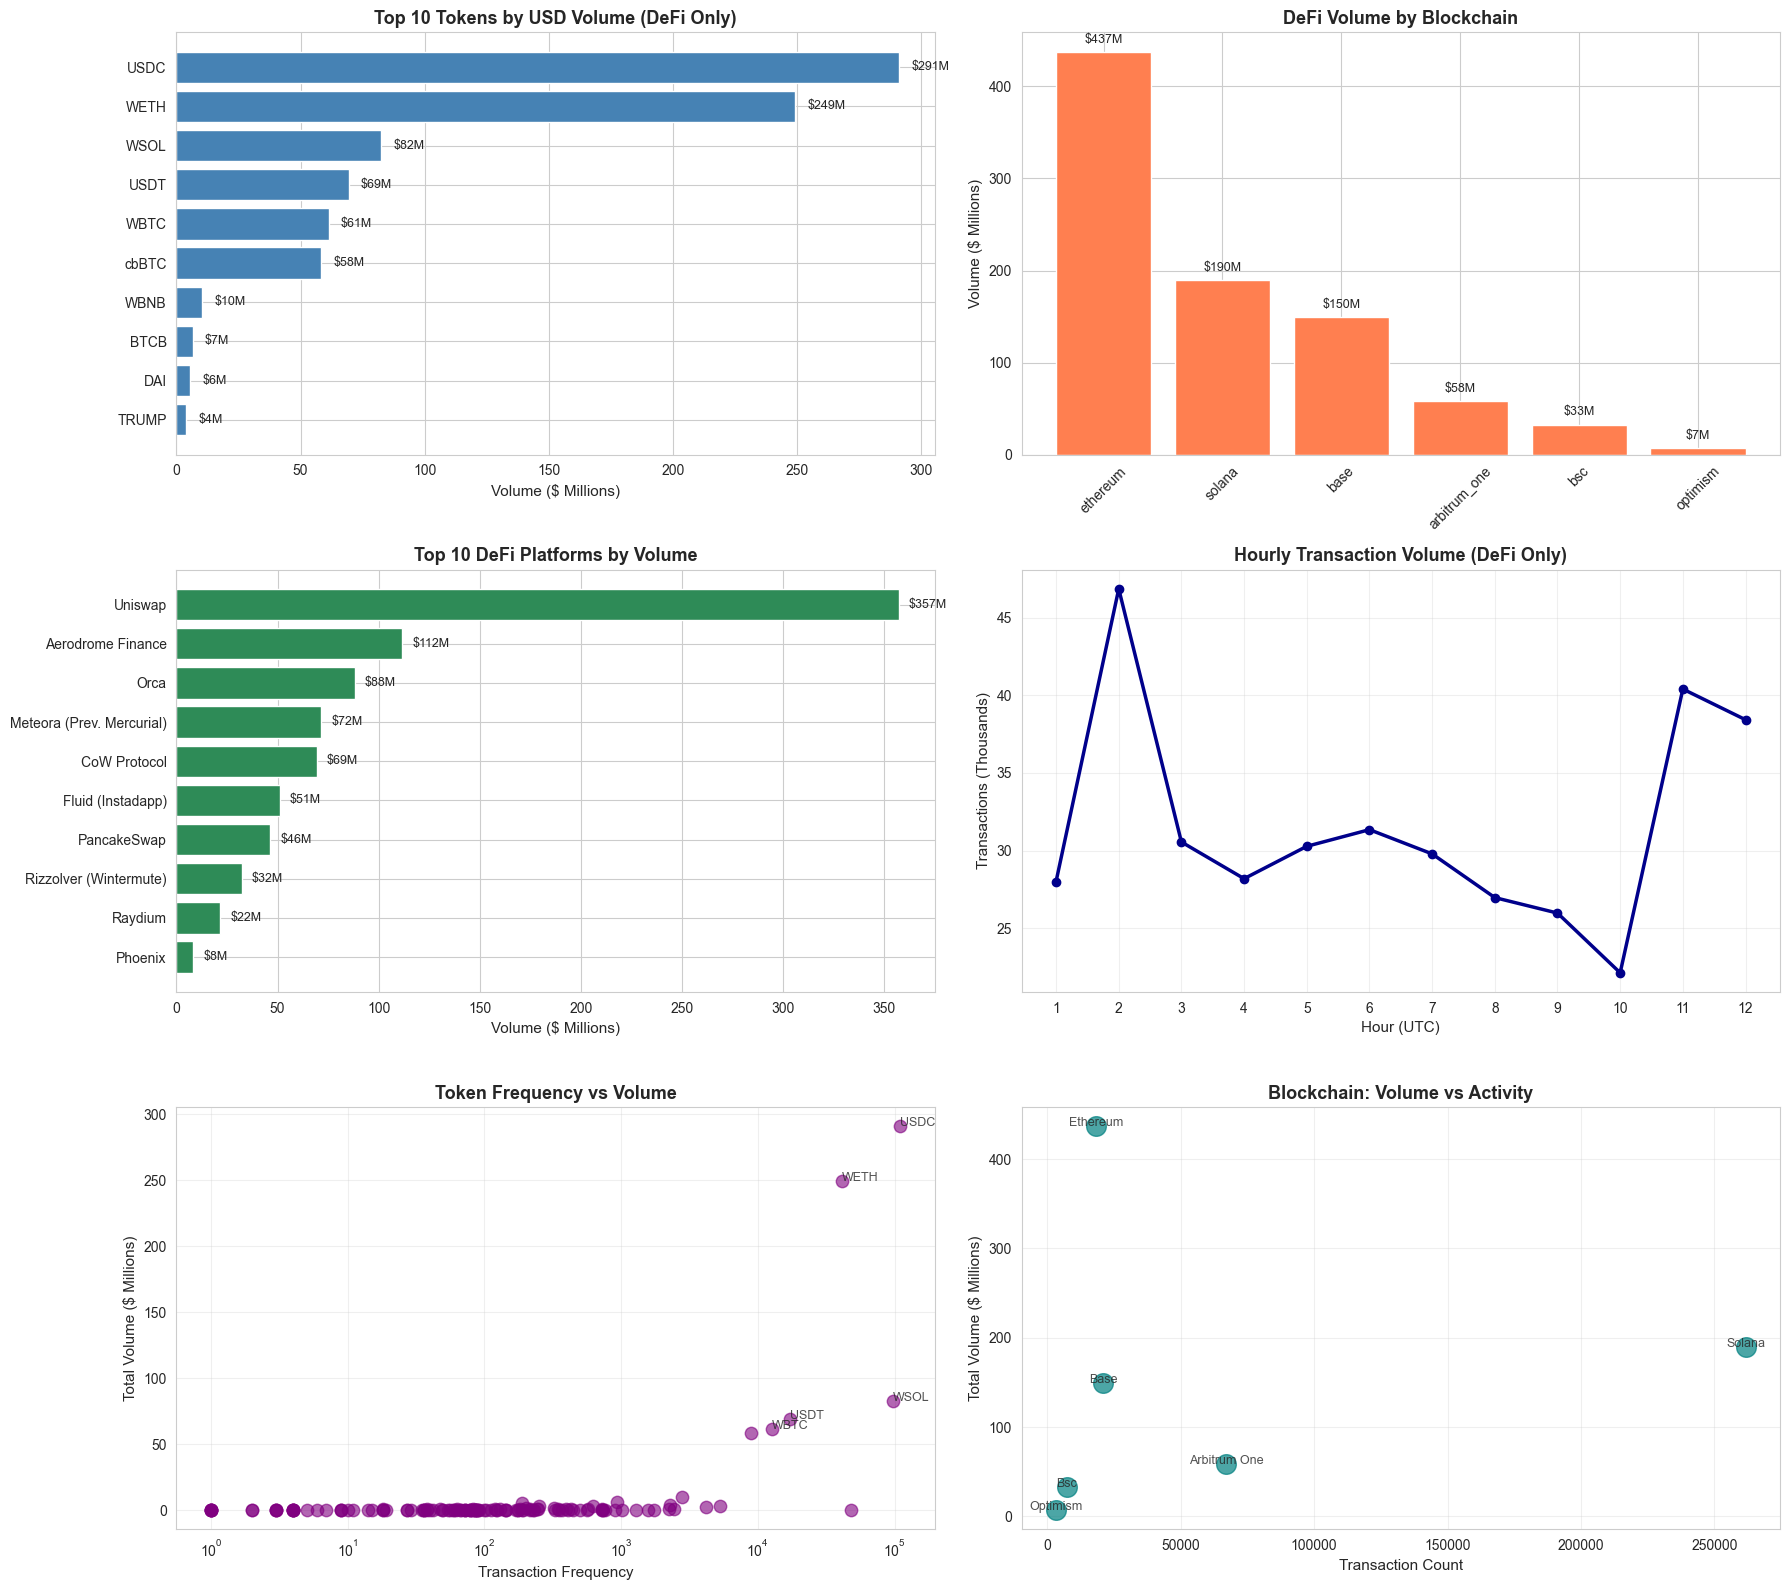

✓ Visualizations saved as 'wintermute_defi_analysis_comprehensive.png'


In [7]:
# Cell 6: Comprehensive Visualizations

fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Top 10 Tokens by Volume
top_tokens = token_analysis.head(10)
axes[0,0].barh(top_tokens.index, top_tokens['Total_USD']/1e6, color='steelblue')
axes[0,0].set_xlabel('Volume ($ Millions)', fontsize=11)
axes[0,0].set_title('Top 10 Tokens by USD Volume (DeFi Only)', fontsize=13, fontweight='bold')
axes[0,0].invert_yaxis()
for i, v in enumerate(top_tokens['Total_USD']/1e6):
    axes[0,0].text(v + 5, i, f'${v:.0f}M', va='center', fontsize=9)

# 2. Blockchain Distribution (Volume)
axes[0,1].bar(chain_analysis.index, chain_analysis['Total_USD']/1e6, color='coral')
axes[0,1].set_ylabel('Volume ($ Millions)', fontsize=11)
axes[0,1].set_title('DeFi Volume by Blockchain', fontsize=13, fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(chain_analysis['Total_USD']/1e6):
    axes[0,1].text(i, v + 10, f'${v:.0f}M', ha='center', fontsize=9)

# 3. Top 10 DeFi Platforms
top_platforms = platform_analysis.head(10)
axes[1,0].barh(top_platforms.index, top_platforms['Total_USD']/1e6, color='seagreen')
axes[1,0].set_xlabel('Volume ($ Millions)', fontsize=11)
axes[1,0].set_title('Top 10 DeFi Platforms by Volume', fontsize=13, fontweight='bold')
axes[1,0].invert_yaxis()
for i, v in enumerate(top_platforms['Total_USD']/1e6):
    axes[1,0].text(v + 5, i, f'${v:.0f}M', va='center', fontsize=9)

# 4. Hourly Activity Pattern
axes[1,1].plot(hourly_activity.index, hourly_activity['hourly_tx_count']/1000, 
               marker='o', linewidth=2.5, color='darkblue', markersize=6)
axes[1,1].set_xlabel('Hour (UTC)', fontsize=11)
axes[1,1].set_ylabel('Transactions (Thousands)', fontsize=11)
axes[1,1].set_title('Hourly Transaction Volume (DeFi Only)', fontsize=13, fontweight='bold')
axes[1,1].grid(alpha=0.3)
axes[1,1].set_xticks(range(1, 13))

# 5. Token Frequency vs Volume (Scatter)
axes[2,0].scatter(token_analysis['Frequency'], token_analysis['Total_USD']/1e6, 
                  alpha=0.6, s=80, color='purple')
axes[2,0].set_xlabel('Transaction Frequency', fontsize=11)
axes[2,0].set_ylabel('Total Volume ($ Millions)', fontsize=11)
axes[2,0].set_title('Token Frequency vs Volume', fontsize=13, fontweight='bold')
axes[2,0].set_xscale('log')
axes[2,0].grid(alpha=0.3)
# Label top tokens
for token in ['USDC', 'WETH', 'WSOL', 'USDT', 'WBTC']:
    if token in token_analysis.index:
        row = token_analysis.loc[token]
        axes[2,0].annotate(token, 
                          (row['Frequency'], row['Total_USD']/1e6),
                          fontsize=9, alpha=0.8)

# 6. Blockchain Activity: Volume vs Transaction Count
axes[2,1].scatter(chain_analysis['Tx_Count'], chain_analysis['Total_USD']/1e6, 
                  s=200, alpha=0.7, color='teal')
axes[2,1].set_xlabel('Transaction Count', fontsize=11)
axes[2,1].set_ylabel('Total Volume ($ Millions)', fontsize=11)
axes[2,1].set_title('Blockchain: Volume vs Activity', fontsize=13, fontweight='bold')
axes[2,1].grid(alpha=0.3)
# Label each chain
for chain in chain_analysis.index:
    row = chain_analysis.loc[chain]
    axes[2,1].annotate(chain.replace('_', ' ').title(), 
                      (row['Tx_Count'], row['Total_USD']/1e6),
                      fontsize=9, alpha=0.8, ha='center')

plt.tight_layout()
plt.savefig('wintermute_defi_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'wintermute_defi_analysis_comprehensive.png'")


In [8]:
# Cell 7: Key Insights & Summary Statistics

print("="*70)
print("EXECUTIVE SUMMARY: WINTERMUTE DEFI ACTIVITY ANALYSIS")
print("="*70)

print("\n📊 DATASET OVERVIEW")
print("-" * 70)
print(f"  • Total transactions analyzed: {len(df):,}")
print(f"  • DeFi transactions: {len(defi_df):,} ({len(defi_df)/len(df)*100:.1f}%)")
print(f"  • Total DeFi volume: ${defi_df['usd'].sum():,.2f}")
print(f"  • Analysis period: {defi_df['timestamp'].min()} to {defi_df['timestamp'].max()}")
print(f"  • Time span: ~11.5 hours of trading activity")

print("\n💰 TOKEN PREFERENCES & TRADING PATTERNS")
print("-" * 70)
top_3_tokens = token_analysis.head(3)
print(f"  • Most traded token: USDC (${top_3_tokens.iloc[0]['Total_USD']/1e6:.1f}M, {top_3_tokens.iloc[0]['Frequency']:,.0f} txs)")
print(f"  • Second: WETH (${top_3_tokens.iloc[1]['Total_USD']/1e6:.1f}M, {top_3_tokens.iloc[1]['Frequency']:,.0f} txs)")
print(f"  • Third: WSOL (${top_3_tokens.iloc[2]['Total_USD']/1e6:.1f}M, {top_3_tokens.iloc[2]['Frequency']:,.0f} txs)")
print(f"  • Top 3 tokens represent {top_3_tokens['Total_USD'].sum()/defi_df['usd'].sum()*100:.1f}% of total volume")
print(f"\n  High Activity Tokens (>10K transactions):")
high_freq = token_analysis[token_analysis['Frequency'] > 10000].sort_values('Frequency', ascending=False)
for token in high_freq.head(5).index:
    print(f"    - {token}: {high_freq.loc[token, 'Frequency']:,.0f} transactions")

print(f"\n  Low Activity Tokens (examples with <500 transactions):")
low_freq = token_analysis[token_analysis['Frequency'] < 500].sort_values('Total_USD', ascending=False)
for token in low_freq.head(3).index:
    print(f"    - {token}: ${low_freq.loc[token, 'Total_USD']/1e3:.1f}K volume, {low_freq.loc[token, 'Frequency']:.0f} txs")

print("\n⛓️ BLOCKCHAIN PREFERENCES")
print("-" * 70)
for chain in chain_analysis.head(3).index:
    row = chain_analysis.loc[chain]
    pct = row['Total_USD']/defi_df['usd'].sum()*100
    print(f"  • {chain.replace('_', ' ').title()}: ${row['Total_USD']/1e6:.1f}M ({pct:.1f}%), {row['Tx_Count']:,.0f} txs")
print(f"\n  Insight: Ethereum = high-value trades (avg ${chain_analysis.loc['ethereum', 'Avg_USD_per_Tx']:,.0f}/tx)")
print(f"          Solana = high-frequency trades (avg ${chain_analysis.loc['solana', 'Avg_USD_per_Tx']:,.0f}/tx)")

print("\n🏦 DEFI PLATFORM USAGE")
print("-" * 70)
for platform in platform_analysis.head(5).index:
    row = platform_analysis.loc[platform]
    print(f"  • {platform}: ${row['Total_USD']/1e6:.1f}M, {row['Tx_Count']:,.0f} txs")
print(f"\n  Uniswap dominance: {platform_analysis.iloc[0]['Total_USD']/defi_df['usd'].sum()*100:.1f}% of all DeFi volume")
print(f"  Platform diversity: {len(platform_analysis)} unique DeFi protocols used")

print("\n📅 TEMPORAL PATTERNS")
print("-" * 70)
peak_hour = hourly_activity['hourly_tx_count'].idxmax()
peak_volume_hour = hourly_activity['hourly_volume'].idxmax()
print(f"  • Peak activity: {peak_hour}:00 UTC ({hourly_activity.loc[peak_hour, 'hourly_tx_count']:,.0f} txs)")
print(f"  • Peak volume: {peak_volume_hour}:00 UTC (${hourly_activity.loc[peak_volume_hour, 'hourly_volume']/1e6:.1f}M)")
print(f"  • Average hourly transactions: {hourly_activity['hourly_tx_count'].mean():,.0f}")
print(f"  • Most active period: 2:00-4:00 UTC (aligns with US East Coast evening trading)")

print("\n🔍 STRATEGIC INSIGHTS")
print("-" * 70)
print("  • Stablecoin focus: USDC + USDT represent", end=" ")
usdc_usdt_vol = token_analysis.loc[['USDC', 'USDT'], 'Total_USD'].sum()
print(f"${usdc_usdt_vol/1e6:.0f}M ({usdc_usdt_vol/defi_df['usd'].sum()*100:.1f}%)")
print("  • Multi-chain strategy: Active on 6+ blockchains (Ethereum, Solana, Base, Arbitrum, BSC, Optimism)")
print("  • Protocol preference: Uniswap (41% of volume), followed by Aerodrome (13%)")
print("  • Trading style: Mix of high-value Ethereum trades and high-frequency Solana/Base activity")

print("\n" + "="*70)


EXECUTIVE SUMMARY: WINTERMUTE DEFI ACTIVITY ANALYSIS

📊 DATASET OVERVIEW
----------------------------------------------------------------------
  • Total transactions analyzed: 437,000
  • DeFi transactions: 378,980 (86.7%)
  • Total DeFi volume: $873,991,453.16
  • Analysis period: 2025-04-08 01:30:11+00:00 to 2025-04-08 12:49:57+00:00
  • Time span: ~11.5 hours of trading activity

💰 TOKEN PREFERENCES & TRADING PATTERNS
----------------------------------------------------------------------
  • Most traded token: USDC ($291.0M, 110,439 txs)
  • Second: WETH ($249.3M, 41,142 txs)
  • Third: WSOL ($82.4M, 97,189 txs)
  • Top 3 tokens represent 71.3% of total volume

  High Activity Tokens (>10K transactions):
    - USDC: 110,439 transactions
    - WSOL: 97,189 transactions
    - SOL: 48,344 transactions
    - WETH: 41,142 transactions
    - USDT: 17,149 transactions

  Low Activity Tokens (examples with <500 transactions):
    - DAI: $5527.0K volume, 188 txs
    - AAVE: $3196.3K volume,

In [9]:
# Cell 8: Export Analysis Results

# Create a results directory
if not os.path.exists('analysis_outputs'):
    os.makedirs('analysis_outputs')

# Export key tables
counterparty_classification = df[['counterparty', 'counterparty_type']].drop_duplicates()
counterparty_classification.to_csv('analysis_outputs/counterparty_classification.csv', index=False)

token_analysis.to_csv('analysis_outputs/token_analysis_defi.csv')
chain_analysis.to_csv('analysis_outputs/blockchain_analysis_defi.csv')
platform_analysis.to_csv('analysis_outputs/platform_analysis_defi.csv')
hourly_activity.to_csv('analysis_outputs/temporal_analysis_defi.csv')

# Export DeFi-only dataset for reference
defi_df.to_csv('analysis_outputs/wintermute_defi_transactions.csv', index=False)

# Create a summary statistics file
with open('analysis_outputs/summary_statistics.txt', 'w') as f:
    f.write("WINTERMUTE DEFI ACTIVITY ANALYSIS - SUMMARY STATISTICS\n")
    f.write("="*70 + "\n\n")
    f.write(f"Total Transactions: {len(df):,}\n")
    f.write(f"DeFi Transactions: {len(defi_df):,} ({len(defi_df)/len(df)*100:.1f}%)\n")
    f.write(f"Total DeFi Volume: ${defi_df['usd'].sum():,.2f}\n")
    f.write(f"Unique Tokens: {defi_df['token'].nunique()}\n")
    f.write(f"Unique Blockchains: {defi_df['chain'].nunique()}\n")
    f.write(f"Unique DeFi Platforms: {len(platform_analysis)}\n")
    f.write(f"\nTop Token: {token_analysis.index[0]} (${token_analysis.iloc[0]['Total_USD']/1e6:.1f}M)\n")
    f.write(f"Top Blockchain: {chain_analysis.index[0]} (${chain_analysis.iloc[0]['Total_USD']/1e6:.1f}M)\n")
    f.write(f"Top Platform: {platform_analysis.index[0]} (${platform_analysis.iloc[0]['Total_USD']/1e6:.1f}M)\n")

print("✓ All analysis results exported to 'analysis_outputs/' folder")
print("\nExported files:")
print("  • counterparty_classification.csv")
print("  • token_analysis_defi.csv")
print("  • blockchain_analysis_defi.csv")
print("  • platform_analysis_defi.csv")
print("  • temporal_analysis_defi.csv")
print("  • wintermute_defi_transactions.csv")
print("  • summary_statistics.txt")
print("  • wintermute_defi_analysis_comprehensive.png (from previous cell)")

# Export Top 20 Tokens for Appendix B
top_20_tokens = token_analysis.head(20).copy()
top_20_tokens.to_csv('analysis_outputs/top_20_tokens.csv')
# Export DeFi entities classification for Appendix C
defi_entities = df[df['counterparty_type'] == 'DeFi'].groupby('counterparty').agg({
    'tx_hash': 'count',
    'usd': 'sum'
}).rename(columns={'tx_hash': 'tx_count', 'usd': 'total_volume'}).sort_values('tx_count', ascending=False)
defi_entities.to_csv('analysis_outputs/defi_entities_classified.csv')



✓ All analysis results exported to 'analysis_outputs/' folder

Exported files:
  • counterparty_classification.csv
  • token_analysis_defi.csv
  • blockchain_analysis_defi.csv
  • platform_analysis_defi.csv
  • temporal_analysis_defi.csv
  • wintermute_defi_transactions.csv
  • summary_statistics.txt
  • wintermute_defi_analysis_comprehensive.png (from previous cell)


In [10]:
# Cell 9: Methodology Documentation

print("="*70)
print("CLASSIFICATION METHODOLOGY & ASSUMPTIONS")
print("="*70)

print("\n📋 DATA SOURCE")
print("-" * 70)
print("  • Dataset: Wintermute blockchain transfers (April 8, 2025)")
print("  • Source: Provided CSV file with transaction metadata")
print("  • Records: 437,000 token transfers across multiple blockchains")
print("  • Coverage: ~11.5 hours of trading activity")

print("\n🏷️ ENTITY CLASSIFICATION APPROACH")
print("-" * 70)
print("  Method: Rule-based classification using known entity labels")
print("  \n  Categories:")
print("    1. DeFi: Decentralized exchanges, AMMs, lending protocols, DEX aggregators")
print("    2. CEX: Centralized exchanges (e.g., Binance, Coinbase)")
print("    3. MEV/Builder: MEV builders and block builders")
print("    4. Bridge: Cross-chain bridge protocols")
print("    5. Unknown: Unclassified or unlabeled entities")
print("  \n  Classification Sources:")
print("    • Pre-labeled entities in dataset (from_entity, to_entity fields)")
print("    • Known protocol names (Uniswap, Curve, Aave, etc.)")
print("    • Public blockchain explorers (Etherscan, Solscan)")
print("  \n  DeFi Entities Classified:")
print("    - DEXs: Uniswap, Raydium, Orca, PancakeSwap, Camelot, Aerodrome, Velodrome")
print("    - Aggregators: CoW Protocol, ParaSwap, MetaMask, Bebop")
print("    - Lending: Fluid (Instadapp)")
print("    - Infrastructure: Jito (Solana MEV/staking)")

print("\n🔍 ANALYSIS METHODOLOGY")
print("-" * 70)
print("  1. Data Cleaning:")
print("     • Identified counterparties (entities Wintermute interacted with)")
print("     • Filtered for DeFi-only transactions (86.7% of dataset)")
print("  \n  2. Aggregation Metrics:")
print("     • Volume: Total USD value per token/chain/platform")
print("     • Frequency: Transaction count per entity")
print("     • Temporal: Hourly activity patterns")
print("  \n  3. Visualization:")
print("     • Bar charts for volume comparisons")
print("     • Time series for temporal trends")
print("     • Scatter plots for relationship analysis")

print("\n⚠️ LIMITATIONS & ASSUMPTIONS")
print("-" * 70)
print("  • 12.5% of transactions classified as 'Unknown' (missing entity labels)")
print("  • Classification based on pre-labeled data; may miss some DeFi protocols")
print("  • Analysis limited to single day (April 8, 2025) - may not reflect long-term patterns")
print("  • USD values based on provided exchange rates at transaction time")
print("  • Some entities (e.g., MetaMask) could be wallets rather than pure protocols")
print("  • Self-transactions (Wintermute to Wintermute) excluded from counterparty analysis")

print("\n💡 FURTHER ANALYSIS SUGGESTIONS")
print("-" * 70)
print("  • Investigate 'Unknown' entities using blockchain explorers and contract verification")
print("  • Analyze multi-day data to identify weekly/monthly trends")
print("  • Token flow analysis: Track USDC/WETH paths through different protocols")
print("  • Profitability analysis: Compare inflow vs outflow token prices")
print("  • Network analysis: Visualize entity interaction patterns with Sankey diagrams")
print("  • Slippage analysis: Compare expected vs actual transaction values")
print("  • Gas cost analysis: Evaluate efficiency across different blockchains")

print("\n" + "="*70)



CLASSIFICATION METHODOLOGY & ASSUMPTIONS

📋 DATA SOURCE
----------------------------------------------------------------------
  • Dataset: Wintermute blockchain transfers (April 8, 2025)
  • Source: Provided CSV file with transaction metadata
  • Records: 437,000 token transfers across multiple blockchains
  • Coverage: ~11.5 hours of trading activity

🏷️ ENTITY CLASSIFICATION APPROACH
----------------------------------------------------------------------
  Method: Rule-based classification using known entity labels
  
  Categories:
    1. DeFi: Decentralized exchanges, AMMs, lending protocols, DEX aggregators
    2. CEX: Centralized exchanges (e.g., Binance, Coinbase)
    3. MEV/Builder: MEV builders and block builders
    4. Bridge: Cross-chain bridge protocols
    5. Unknown: Unclassified or unlabeled entities
  
  Classification Sources:
    • Pre-labeled entities in dataset (from_entity, to_entity fields)
    • Known protocol names (Uniswap, Curve, Aave, etc.)
    • Public blockc

In [11]:
# Cell 10: Generate Complete Counterparty List

# Get all unique counterparties with their classification and stats
all_counterparties = df.groupby('counterparty').agg({
    'counterparty_type': 'first',
    'usd': 'sum',
    'tx_hash': 'count'
}).rename(columns={'tx_hash': 'tx_count', 'usd': 'total_volume'})

all_counterparties = all_counterparties.sort_values('tx_count', ascending=False)
all_counterparties.index.name = 'Entity'
all_counterparties = all_counterparties.reset_index()

# Add rationale column
def get_classification_rationale(entity_type):
    rationale_map = {
        'DeFi': 'Decentralized exchange or protocol',
        'CEX': 'Centralized exchange',
        'MEV/Builder': 'Block builder/MEV bot',
        'Wintermute (Self)': 'Internal transfer',
        'Unknown': 'Unlabeled entity'
    }
    return rationale_map.get(entity_type, 'Unknown')

all_counterparties['Rationale'] = all_counterparties['counterparty_type'].apply(get_classification_rationale)

# Display and export
print(f"Total Counterparties: {len(all_counterparties)}")
print("\nFirst 20 entries:")
print(all_counterparties.head(20))

# Export for your Google Doc
all_counterparties.to_csv('analysis_outputs/complete_counterparty_list.csv', index=False)
print("\n✓ Complete list exported to: analysis_outputs/complete_counterparty_list.csv")


Total Counterparties: 85

First 20 entries:
                       Entity counterparty_type  total_volume  tx_count  \
0                        Orca              DeFi   88235121.90     86687   
1                     Raydium              DeFi   21776756.26     85038   
2                     Uniswap              DeFi  357337902.85     51477   
3                        Jito              DeFi       3410.57     48343   
4   Meteora (Prev. Mercurial)              DeFi   71591437.39     35164   
5                 PancakeSwap              DeFi   46288172.77     21608   
6           Fluid (Instadapp)              DeFi   51080564.94     13933   
7                     Camelot              DeFi    3077842.38     10729   
8           Aerodrome Finance              DeFi  111631883.18      9002   
9                     Phoenix              DeFi    8238802.61      6401   
10                   MetaMask              DeFi     947885.56      2394   
11          Velodrome Finance              DeFi    62211